In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import sys
sys.path.append('../src/')
#sys.path.append('/n/des/lee.5922/programs/cosmolike/MG_musigma/')
from noshellavg_v2 import *
from mock_test import *
#from run_error_analysis import *
#from plot_chain import plot_single, plot_triple, plot_distributions, plot_summary_bar
%matplotlib inline

%load_ext autoreload
%autoreload 2

# Modelling DESI targets redshift distributions

## Draw quantities

Quantities from http://arxiv.org/abs/1611.00036

In [65]:
def construct_galaxy_catalog( Area=14000, z=None, Vs=None, dN_dzdA=None, bD=None ):
    
    mask = (np.array(dN_dzdA) != 0.)
    
    Dic_gal = {}
    Dic_gal['Area'] = Area
    Dic_gal['z'] = np.array(z)
    Dic_gal['dz'] = Dic_gal['z'][2] - Dic_gal['z'][1]
    Dic_gal['z_low'] = Dic_gal['z']-0.5*Dic_gal['dz']
    Dic_gal['Vs'] = np.array(Vs) * 1e+09
    Dic_gal['Vs_total'] = np.sum(Dic_gal['Vs'][mask])

    Dic_gal['dN_dzdA'] = np.array(dN_dzdA)
    Dic_gal['N'] = Dic_gal['dN_dzdA'] * Dic_gal['dz'] * Dic_gal['Area']
    Dic_gal['N_total'] = np.sum(Dic_gal['N'])
    Dic_gal['nbar'] = Dic_gal['N']/Dic_gal['Vs']
    Dic_gal['nbar_total'] = Dic_gal['N_total']/Dic_gal['Vs_total']

    Dic_gal['z_eff'] = np.sum( Dic_gal['z']*Dic_gal['N'] )*1./np.sum(Dic_gal['N'])
    Dic_gal['bD'] = bD
    
    Dic_gal['nbar_area']= Dic_gal['N_total']/Dic_gal['Area']
    
    print ' '
    print 'z_eff={:0.2f}'.format(Dic_gal['z_eff'])
    print 'redshift: {} < z < {}'.format(Dic_gal['z_low'][mask][0], Dic_gal['z_low'][mask][-1]+Dic_gal['dz'])
    print 'Vs_total(Gpc^3)=', Dic_gal['Vs_total']/1e+09
    print 'N_total={:0.0f}'.format(Dic_gal['N_total'])
    print 'nbar_total(10^-4)={:0.3f}'.format(Dic_gal['nbar_total'] * 1e+04)
    print 'nbar_area(/deg^2)={:0.3f}'.format(Dic_gal['nbar_area'])
    print 'b(z)={:0.2f} x D(0)/D(z)'.format(bD)

    return Dic_gal

In [ ]:
Dic_CMASS_LRG = construct_galaxy_catalog(Area=14000, 
                                  bD=1.7,
                                  z=[0.65,0.75,0.85,0.95],
                                  Vs=[02.63,3.15,3.65,4.10],
                                  dN_dzdA=[832,986,662,272,51,17])

In [66]:
Dic_BGS = construct_galaxy_catalog(Area=14000, 
                                   bD=1.34, 
                                  z=[0.05, 0.15, 0.25, 0.35, 0.45],
                                  Vs=[0.04, 0.23, 0.58, 1.04, 1.55],
                                  dN_dzdA=[1165,3074,1909,732,120])


z = [0.65,0.75,0.85,0.95,1.05,1.15,1.25,1.35,1.45,1.55,1.65]
Vs = [02.63,3.15,3.65,4.10,4.52,4.89,5.22,5.50,5.75,5.97,6.15]

Dic_LRG = construct_galaxy_catalog(Area=14000, 
                                   bD=1.7,
                                  z=z,
                                  Vs=Vs,
                                  dN_dzdA=[832,986,662,272,51,17,0,0,0,0,0])

Dic_ELG = construct_galaxy_catalog(Area=14000, 
                                   bD=0.84,
                                  z=z,
                                  Vs=Vs,
                                  dN_dzdA=[309,2269,1923,2094,1441,1353,1337,523,466,329,126])

 
z_eff=0.19
redshift: 0.0 < z < 0.5
Vs_total(Gpc^3)= 3.44
N_total=9800000
nbar_total(10^-4)=28.488
nbar_area(/deg^2)=700.000
b(z)=1.34 x D(0)/D(z)
 
z_eff=0.77
redshift: 0.6 < z < 1.2
Vs_total(Gpc^3)= 22.94
N_total=3948000
nbar_total(10^-4)=1.721
nbar_area(/deg^2)=282.000
b(z)=1.70 x D(0)/D(z)
 
z_eff=1.02
redshift: 0.6 < z < 1.7
Vs_total(Gpc^3)= 51.53
N_total=17038000
nbar_total(10^-4)=3.306
nbar_area(/deg^2)=1217.000
b(z)=0.84 x D(0)/D(z)


Save dictionary

In [67]:
import pickle

dir = '/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/'
f = open(dir+"DIC_DESI_BGS.pkl","wb")
pickle.dump(Dic_BGS,f)
f.close()

f = open(dir+"DIC_DESI_LRG.pkl","wb")
pickle.dump(Dic_LRG,f)
f.close()

f = open(dir+"DIC_DESI_ELG.pkl","wb")
pickle.dump(Dic_ELG,f)
f.close()

## Make redshift distribution

In [155]:
def pz_debono(a,b,c,z0):
    
    zbin, dz = np.linspace(0.0, 4.0, 401, retstep=True)
    zcenter = zbin[:-1] + dz/2.
    pnz= (zcenter-c)**a * np.exp( -( (zcenter-c)/z0)**b  )
    nanmask = (zcenter < c) 
    pnz[nanmask] = 0.0 
    pnz_integ = np.sum(pnz) #
    #pnz_integ = simps( pnz, zcenter )
    pnz_norm = pnz/pnz_integ
    
    pnz_norm[pnz_norm<1e-09] = 0.0
    
    print 'zeff={:0.2f}'.format(np.sum(zcenter*pnz_norm))
    
    return zbin[:-1], zcenter, pnz_norm

In [209]:
#zlow, zcenter, pz_bgs = pz_debono(2, 2, 0.0, 0.17)
#zlow, zcenter, pz_lrg = pz_debono(2, 2, 0.5, 0.24)
#zlow, zcenter, pz_elg = pz_debono(2, 2, 0.5, 0.46)

zeff=0.19
zeff=0.77
zeff=1.02


In [210]:
zlow, zcenter, pz_bgs = pz_debono(1, 2, 0.0, 0.2)
zlow, zcenter, pz_lrg = pz_debono(1, 2, 0.6, 0.2)
zlow, zcenter, pz_elg = pz_debono(1, 2, 0.6, 0.5)

zeff=0.18
zeff=0.78
zeff=1.04


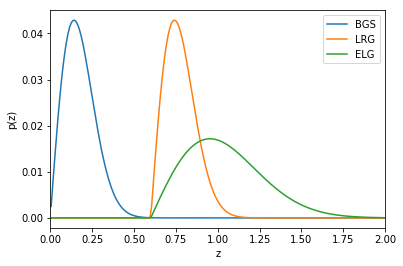

In [211]:
fig, ax = plt.subplots()
ax.plot(zcenter, pz_bgs, label='BGS' )
ax.plot(zcenter, pz_lrg, label='LRG' )
ax.plot(zcenter, pz_elg, label='ELG' )
ax.set_xlim(0,2)
ax.legend()
ax.set_xlabel('z')
ax.set_ylabel('p(z)')

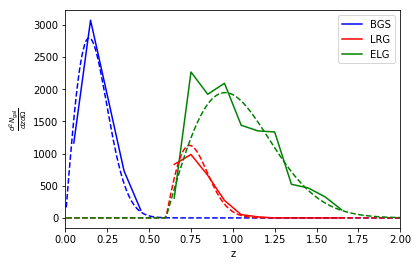

In [212]:
fig, ax = plt.subplots()
ax.plot(Dic_BGS['z'], Dic_BGS['dN_dzdA'], 'b-', label='BGS' )
ax.plot(Dic_LRG['z'], Dic_LRG['dN_dzdA'], 'r-', label='LRG' )
ax.plot(Dic_ELG['z'], Dic_ELG['dN_dzdA'], 'g-',label='ELG' )

ax.plot(zcenter, pz_bgs * Dic_BGS['N_total']/150, 'b--',  )
ax.plot(zcenter, pz_lrg * Dic_LRG['N_total']/150, 'r--', )
ax.plot(zcenter, pz_elg * Dic_ELG['N_total']/150, 'g--', )

ax.legend()
ax.set_xlim(0,2)
ax.set_xlabel('z')
ax.set_ylabel('$\\frac{d^2 N_{\\rm gal}}{dzd \Omega}$')

In [174]:
redshift_dat = np.column_stack(( zlow, pz_bgs, pz_lrg, pz_elg  ))
redshift_dat_bgs = np.column_stack(( zlow, pz_bgs ))
redshift_dat_lrg = np.column_stack(( zlow, pz_lrg ))
redshift_dat_elg = np.column_stack(( zlow, pz_elg  ))

In [118]:
ls /n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/nz_desi_*

/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/nz_desi_all.txt
/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/nz_desi_all_v2.txt
/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/nz_desi_bgs_elg.txt
/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/nz_desi_bgs.txt
/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/nz_desi_bgs_v2.txt
/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/nz_desi_elg.txt
/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/nz_desi_elg_v2.txt
/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/nz_desi_lrg.txt
/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/nz_desi_lrg_v2.txt


In [175]:
np.savetxt('/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/nz_desi_all_v2.txt', redshift_dat, fmt='%.10e')
np.savetxt('/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/nz_desi_bgs_v2.txt', redshift_dat_bgs, fmt='%.10e')
np.savetxt('/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/nz_desi_lrg_v2.txt', redshift_dat_lrg, fmt='%.10e')
np.savetxt('/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/nz_desi_elg_v2.txt', redshift_dat_elg, fmt='%.10e')